# Exercise 1: Introduction to Machine Learning

Some code cells will be marked with 
```
##########################
######## To Do ###########
##########################
```

This indicates that you are being asked to write a piece of code to complete the notebook.

# Part 3: Feature Engineering

Classical machine learning methods often turn to manual feature engineering to extract elements of the data that the model will use for prediction. So far we have relied on the raw data alone, but in some cases well designed features can produce a better model than raw data alone.

In [104]:
import imageio as iio
import skimage
import sklearn.model_selection
import sklearn.utils
import sklearn.metrics
import sklearn.preprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tqdm.auto
import copy

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
        
import tensorflow_addons as tfa

from tensorflow.keras.layers import Input, Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Softmax
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

## General setup
### Load dataset
We will load the same dataset as the previous notebook.

In [5]:
data_dir = 'data/CellCycle'

In [6]:
# Load dataframe with sample info
df = pd.read_csv(os.path.join(data_dir, 'img.lst'), sep='\t', header=None)
df = df.rename(columns={1: 'class', 2: 'filepath'})
df['channel'] = df['filepath'].str.split('/',expand=True)[2].str.split('_', expand=True)[1].str.slice(2,3)
df['id'] = df['filepath'].str.split('/',expand=True)[2].str.split('_', expand=True)[0]
df.head()

,0,class,filepath,channel,id
0,19,0,./Anaphase/12432_Ch3.ome.jpg,3,12432
1,8,0,./Anaphase/12432_Ch4.ome.jpg,4,12432
2,35,0,./Anaphase/12432_Ch6.ome.jpg,6,12432
3,36,0,./Anaphase/22004_Ch3.ome.jpg,3,22004
4,1,0,./Anaphase/22004_Ch4.ome.jpg,4,22004


In [7]:
# Load data stack
ims = []
ys = []
for i, g in df.groupby('id'):
    im = []
    for _, r in g.iterrows():
        im.append(iio.imread(os.path.join(data_dir, r['filepath'])))
    ims.append(np.stack(im, axis=-1))
    ys.append(r['class'])
    
X_data = np.stack(ims)
y_data = np.stack(ys)
print('X shape:', X_data.shape)
print('y shape:', y_data.shape)

/var/folders/cz/1rzgr7p564q00vylf6hzyrgh0000gn/T/ipykernel_41035/2396819062.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im.append(iio.imread(os.path.join(data_dir, r['filepath'])))


X shape: (32266, 66, 66, 3)
y shape: (32266,)


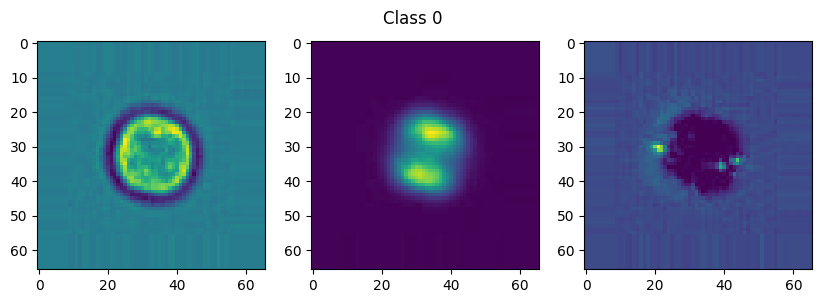

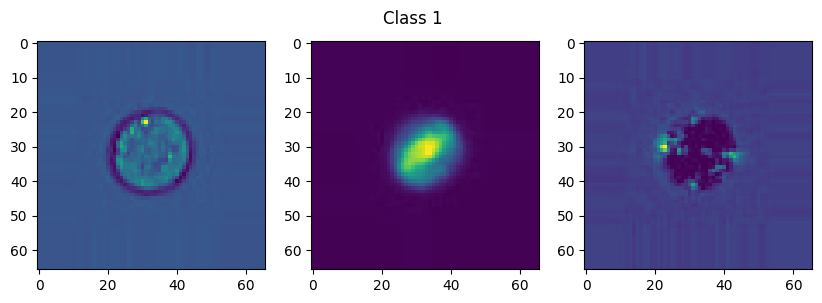

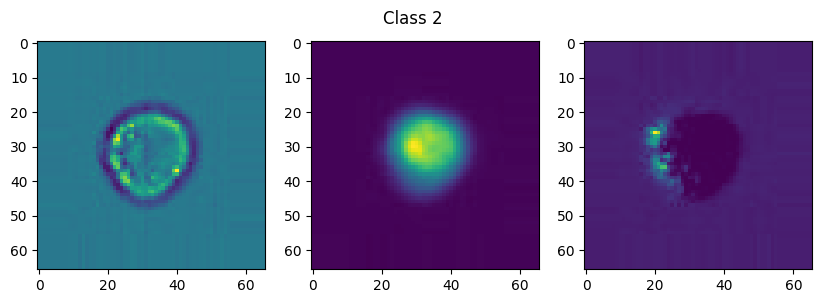

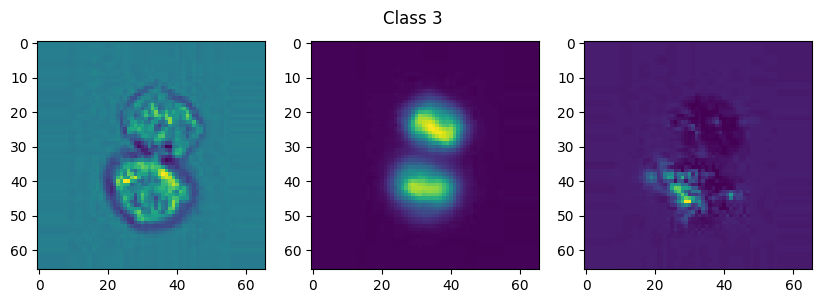

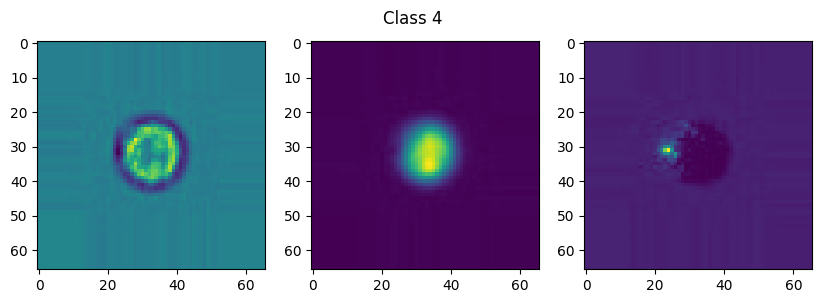

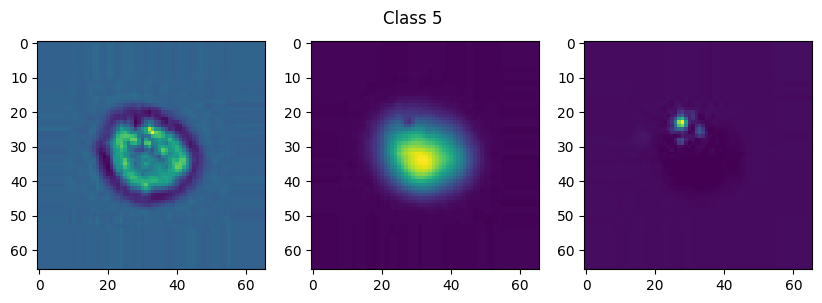

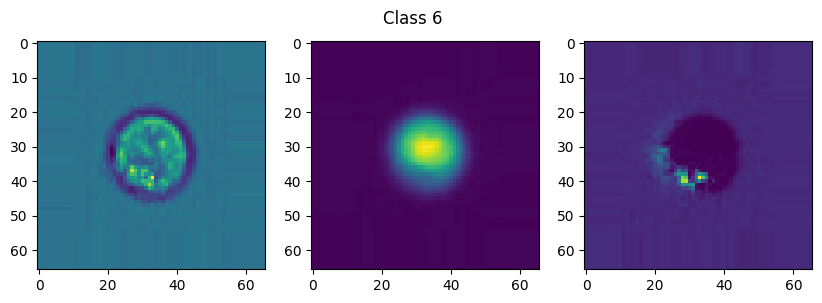

In [8]:
# Plot example image from each class
for c in np.unique(y_data):
    i = np.random.choice(np.where(y_data == c)[0])
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    plt.suptitle('Class {}'.format(c))
    for j in range(3):
        ax[j].imshow(X_data[i,...,j])

For this next section of the exercise, we will try working with two classes that are harder to distinguish.

In [9]:
def extract_classes(X_data, y_data, classes):
    X, y = [], []
    for c in classes:
        # Identify the indicies of the relevant class
        idx = y_data == c
        # Select the X and y data accordingly
        X.append(X_data[idx, ..., 0:1])
        y.append(y_data[idx])

    # Restack the arrays
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y

In [10]:
X, y = extract_classes(X_data, y_data, [4, 5])

print(X.shape, y.shape)

(22934, 66, 66, 1) (22934,)


In [11]:
y[y == 4] = 0
y[y == 5] = 1

In [12]:
def balance_classes(X, y, minority_id):
    """For a given minority class id, upsample the minority class
    to match the number of samples in the majority class
    
    Args:
        X (np.array): Array of raw data
        y (np.array): Array of class labels
        minority_id (int): Integer of the minority class to be upsampled
        
    Returns:
        np.array: X
        np.array: y
    """
    # Split the X and y arrays into sub arrays containing 
    # 1) only the minority samples and 2) the remaining samples
    x_max = X[y != minority_id]
    y_max = y[y != minority_id]
    x_min = X[y == minority_id]
    y_min = y[y == minority_id]
    
    # Use sklearn.utils.resample to samples from the minority sample array 
    # to match the number of samples in the second array
    x_min, y_min = sklearn.utils.resample(x_min, y_min, n_samples=x_max.shape[0])
    
    # Concatenate the upsampled array 1 with the remaining array 2
    X = np.concatenate([x_max, x_min])
    y = np.concatenate([y_max, y_min])
    
    # Shuffle arrays to randomize sample order
    X, y = sklearn.utils.shuffle(X, y)
    
    return X, y


# Create dataset builder
class DatasetBuilder(object):
    def __init__(self,
                 X,
                 y,
                 batch_size=1,
                 rotation_range=180,
                 scale_range=(0.75, 1.25)):
        self.X = X
        self.y = y
        
        self.batch_size = batch_size
        self.rotation_range = np.float(rotation_range)
        self.scale_range = scale_range
        
        # Create dataset
        self._create_dataset()
        
    def _create_dataset(self):
        X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(self.X, self.y, train_size=0.8)
        X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, train_size=0.5)
        
        # Compute counts to determine minority class
        class_ids = np.unique(self.y)
        if np.count_nonzero(self.y == class_ids[0]) >= np.count_nonzero(self.y == class_ids[1]):
            min_id = 1
        else:
            min_id = 0
        
        # Balance classes in each split
        X_train, y_train = balance_classes(X_train, y_train, min_id)
        X_test, y_test = balance_classes(X_test, y_test, min_id)
        X_val, y_val = balance_classes(X_val, y_val, min_id)
        
        # Convert y data to categorical
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
        y_val = tf.keras.utils.to_categorical(y_val)
        
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        
        self.train_dataset = train_dataset.shuffle(256).batch(self.batch_size)
        self.val_dataset = val_dataset.batch(self.batch_size)
        self.test_dataset = test_dataset.batch(self.batch_size)

### Model configuration

In [29]:
# Define the linear classifier
def create_linear_classifier():
    """Defines a basic linear classifier to predict 2 classes and 
    compiles the model with the following:
    - Optimizer = Adam
    - Loss = Categorical Crossentropy
    - Metrics = Recall and precision for each class
    """
    inputs = Input((X.shape[1], X.shape[2], 1),
                   name='linear_classifier_input')
    x = Flatten()(inputs)
    x = Dense(2)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3, clipnorm=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics = [
                      tf.keras.metrics.Recall(class_id=0),
                      tf.keras.metrics.Recall(class_id=1),
                      tf.keras.metrics.Precision(class_id=0),
                      tf.keras.metrics.Precision(class_id=1)
                  ])
    return model

In [14]:
# Define training parameters
training_steps_per_epoch=512
n_epochs=32

In [30]:
def train_model(model, data, n_epochs, model_path):
    """Fits a model using data from a `DatasetBuilder`. 
    The weights of the model are saved in a folder according
    to `model_path`
    
    Args:
        model (tensorflow model): Model from `create_linear_classifier`
        data (DatasetBuilder): Dataset builder object 
        n_epochs (int): Number of epochs to train for
        model_path (str): Path to save model weights
    """
    model.fit(
        data.train_dataset,
        validation_data=data.val_dataset,
        epochs=n_epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                model_path, monitor='val_loss',
                save_best_only=True, verbose=1,
                save_weights_only=False),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, verbose=1,
                patience=3, min_lr=1e-7)
        ]
    )
    return model

### Benchmarking functions

In [16]:
def benchmark_performance(y_true, y_pred):
    """Calculates recall, precision, f1 and a confusion matrix for sample predictions
    
    Args:
        y_true (list): List of integers of true class values
        y_pred (list): List of integers of predicted class value
        cm_norm (optional): 'true' to return a normalized confusion matrix.
            None to return an raw confusion matrix
            
    Returns:
        dict: Dictionary with keys `recall`, `precision`, `f1`, and `cm`
    
    """
    _round = lambda x: round(x, 3)
    
    metrics = {
        'recall': _round(sklearn.metrics.recall_score(y_true, y_pred)),
        'precision': _round(sklearn.metrics.precision_score(y_true, y_pred)),
        'f1': _round(sklearn.metrics.f1_score(y_true, y_pred)),
        'cm': sklearn.metrics.confusion_matrix(y_true, y_pred, normalize=None),
        'cm_norm': sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='true')
    }
    
    return metrics

In [17]:
def plot_metrics(metrics, name, ax=None):
    """Plots a confusion matrix with summary statistics listed above the plot
    
    The annotations on the confusion matrix are the total counts while
    the colormap represents those counts normalized to the total true items
    in that class.
    
    Args:
        metrics (dict): Dictionary output of `benchmark_performance`
        name (str): Title for the plot
        ax (optional, matplotlib subplot): Subplot axis to plot onto. 
            If not provided, a new plot is created
        classes (optional, list): A list of the classes to label the X and y 
            axes. Defaults to [0, 1] for a two class problem.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    cb = ax.imshow(metrics['cm_norm'], cmap='Greens', vmin=0, vmax=1)
    
    classes = np.arange(metrics['cm'].shape[0])
    plt.xticks(range(len(classes)), classes)
    plt.yticks(range(len(classes)), classes)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            color='green' if metrics['cm_norm'][i,j] < 0.5 else 'white'
            ax.annotate('{}'.format(metrics['cm'][i,j]), (j, i),
                        color=color, va='center', ha='center')

    _ = plt.colorbar(cb, ax=ax)
    _ = ax.set_title(
            '{}\n'\
            'Recall: {}\n'\
            'Precision: {}\n'\
            'F1 Score: {}\n'\
            ''.format(name, metrics['recall'], metrics['precision'], metrics['f1'])
        )

## Introduction to image filters

Image filters operate by taking a small kernel (or matrix) and applying it to each pixel in the image to compute a new value. As an example, this is the identiy kernel 
$$
\begin{bmatrix}
    0 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 0 \\
\end{bmatrix}
$$
which when applied to an image will not result in any changes to the data.

Filters can produce a variety of effects on images depending on how the kernel is configured. This can range from blurring an image (center) to extracting edges (right). 

Text(0.5, 1.0, 'Laplace')

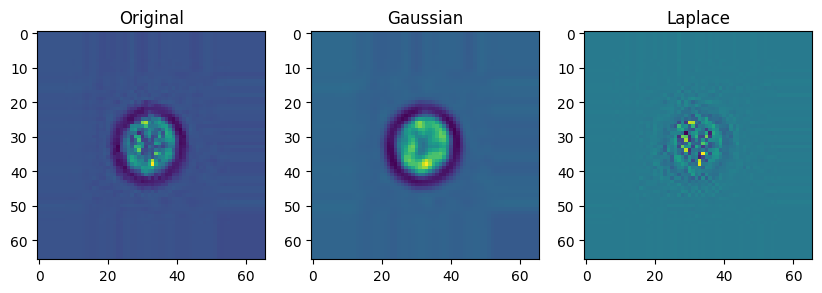

In [19]:
im = X[np.random.randint(X.shape[0]),...,0]
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

ax[0].imshow(im)
ax[0].set_title('Original')

ax[1].imshow(skimage.filters.gaussian(im))
ax[1].set_title('Gaussian')

ax[2].imshow(skimage.filters.laplace(im))
ax[2].set_title('Laplace')

The effect of a filter can also be influenced by changing the sigma parameter which modifies the size of the kernel, as shown below for the Gaussian filter.

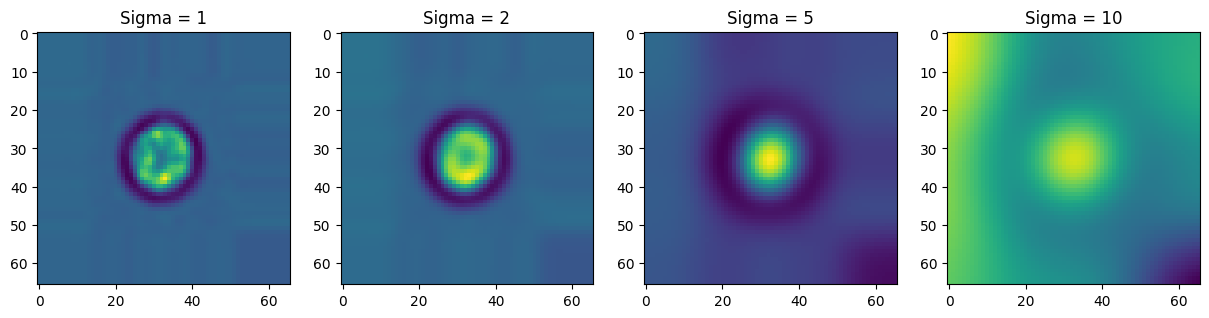

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
sigmas = [1, 2, 5, 10]

for i, s in enumerate(sigmas):
    ax[i].imshow(skimage.filters.gaussian(im, sigma=s))
    ax[i].set_title('Sigma = {}'.format(s))

A variety of filters are made available through the `skimage.filters` [module](https://scikit-image.org/docs/stable/api/skimage.filters.html). In this part of the exercise, we are going to explore how filters can be applied to images in order to extract features for model prediction.

In [23]:
from inspect import getmembers, isfunction

# List all functions in the skimage.filters module to get a list of available filters
[m[0] for m in getmembers(skimage.filters, isfunction)]

['apply_hysteresis_threshold',
 'butterworth',
 'correlate_sparse',
 'difference_of_gaussians',
 'farid',
 'farid_h',
 'farid_v',
 'frangi',
 'gabor',
 'gabor_kernel',
 'gaussian',
 'hessian',
 'inverse',
 'laplace',
 'median',
 'meijering',
 'prewitt',
 'prewitt_h',
 'prewitt_v',
 'rank_order',
 'roberts',
 'roberts_neg_diag',
 'roberts_pos_diag',
 'sato',
 'scharr',
 'scharr_h',
 'scharr_v',
 'sobel',
 'sobel_h',
 'sobel_v',
 'threshold_isodata',
 'threshold_li',
 'threshold_local',
 'threshold_mean',
 'threshold_minimum',
 'threshold_multiotsu',
 'threshold_niblack',
 'threshold_otsu',
 'threshold_sauvola',
 'threshold_triangle',
 'threshold_yen',
 'try_all_threshold',
 'unsharp_mask',
 'wiener',
 'window']

## Explore available filters 

Test a variety of the available filters from the `skimage` module. The goal is to identify a set of filters that you think will lead to better classification results on the two classes we are trying to distinguish.

Keep the following things you may want to keep in mind as you approach this problem
- Look at several randomly selected images from the two classes when you are testing a filter
- Explore the effect of parameters available for each filter

**Challenge**: While this task could be approached by testing filters one at a time, consider writing a for loop to rapidly test filters in an automated fashion.


**Tip**: Within a jupyter notebook, you can run `function?` to look at the documentation for that function. Check out the example below.

In [24]:
skimage.filters.gaussian?

Signature:
skimage.filters.gaussian(
    image,
    sigma=1,
    output=None,
    mode='nearest',
    cval=0,
    multichannel=None,
    preserve_range=False,
    truncate=4.0,
    *,
    channel_axis=None,
)
Docstring:
Multi-dimensional Gaussian filter.

Parameters
----------
image : array-like
    Input image (grayscale or color) to filter.
sigma : scalar or sequence of scalars, optional
    Standard deviation for Gaussian kernel. The standard
    deviations of the Gaussian filter are given for each axis as a
    sequence, or as a single number, in which case it is equal for
    all axes.
output : array, optional
    The ``output`` parameter passes an array in which to store the
    filter output.
mode : {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, optional
    The ``mode`` parameter determines how the array borders are
    handled, where ``cval`` is the value when mode is equal to
    'constant'. Default is 'nearest'.
cval : scalar, optional
    Value to fill past edges of 

In [25]:
##########################
######## To Do ###########
##########################

# Put your code for testing filters here

## Checkpoint

We'll discuss as a group which filters seem like they may be most effective at distinguishing our two classes. Please be prepared with your top two or three candidates. 

*Bonus:* Collect screenshots of your filtering results to share with the group. Look out for a slack message for instructions on how to submit images.

## Training model variants
Starting with a few of your top choices for filters, train a model on each filter variation and compare the results. Again as an extra challenge, you can write a for loop to automate this process.

You will roughly need to follow these steps:
- Create a new version of `X` and `y` with the filter applied. Make sure that you are working on a new copy of the original data each time you apply a filter. You can use `copy.deepcopy` to create a new copy of an array.
- Create a new `DatasetBuilder` object with the filtered images
    ```
    with tf.device('CPU:0'):
        db = DatasetBuilder(X, y, batch_size=64)
    ```
- Train a model using the functions `create_linear_classifier` and `train_model` that are defined in an earlier section of the notebook
- Benchmark and collect the metrics for each model variant 

In [31]:
##########################
######## To Do ###########
##########################

# Your code for training and comparing models here

## Checkpoint

We'll discuss as a group what filters worked best to distinguish between the two classes. Look out for a slack message to share your best results with the group.

## Bonus

If you have extra time, try one of the following challenges:
- How does your selected filter perform on another pair of classes in this dataset?
- Can you automate the search for the top performing filter by writing a function that ultimately reports the top performer?